In [1]:
#connect to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = '/content/drive/MyDrive/mhealth/study/test_submission/'
import os
os.chdir(path)
os.getcwd()

'/content/drive/MyDrive/mhealth/study/test_submission'

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE


In [4]:
# Set the base directory
base_dir = '/content/drive/MyDrive/mhealth/study/test_submission/'
print(f"Using data from: {base_dir}")


for participant in ['p1', 'p2']:
    dim_dir = os.path.join(base_dir, participant, 'dim_reduction')
    if not os.path.exists(dim_dir):
        os.makedirs(dim_dir)
        print(f"Created directory: {dim_dir}")

def load_participant_data(participant_id):
    data_file = os.path.join(base_dir, participant_id, 'data', 'merged_sensor_data.csv')
    if os.path.exists(data_file):
        df = pd.read_csv(data_file)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        return df
    else:
        print(f"Error: Data file not found for {participant_id}")
        return None


def extract_activity_data(df, participant_id):
    # Define activity sessions
    if participant_id == 'p1':
        sessions = {
            'resting': {'start': '2025-03-11 23:42:00', 'end': '2025-03-11 23:48:00', 'color': 'green'},
            'boring': {'start': '2025-03-11 23:50:00', 'end': '2025-03-11 23:55:00', 'color': 'orange'},
            'exciting': {'start': '2025-03-11 23:57:00', 'end': '2025-03-12 00:02:00', 'color': 'red'}
        }
    else:  # p2
        sessions = {
            'resting': {'start': '2025-03-12 00:15:29', 'end': '2025-03-12 00:20:29', 'color': 'green'},
            'boring': {'start': '2025-03-12 00:21:00', 'end': '2025-03-12 00:26:00', 'color': 'orange'},
            'exciting': {'start': '2025-03-12 00:26:50', 'end': '2025-03-12 00:31:50', 'color': 'red'}
        }

    activity_data = {}
    for activity_type, session in sessions.items():
        start_time = pd.to_datetime(session['start'])
        end_time = pd.to_datetime(session['end'])

        # Filter data for this activity
        activity_segment = df[(df['timestamp'] >= start_time) &
                             (df['timestamp'] <= end_time)].copy()

        # Add activity type and color as columns
        activity_segment['activity_type'] = activity_type
        activity_segment['color'] = session.get('color', 'blue')
        activity_data[activity_type] = activity_segment

    return activity_data

# Load data for both participants
participant_data = {}
activity_data = {}

for participant in ['p1', 'p2']:
    df = load_participant_data(participant)
    if df is not None:
        participant_data[participant] = df
        activity_data[participant] = extract_activity_data(df, participant)
        print(f"Loaded data for {participant}: {len(df)} rows")

Using data from: /content/drive/MyDrive/mhealth/study/test_submission/
Loaded data for p1: 11472 rows
Loaded data for p2: 10983 rows



Performing PCA for p1...


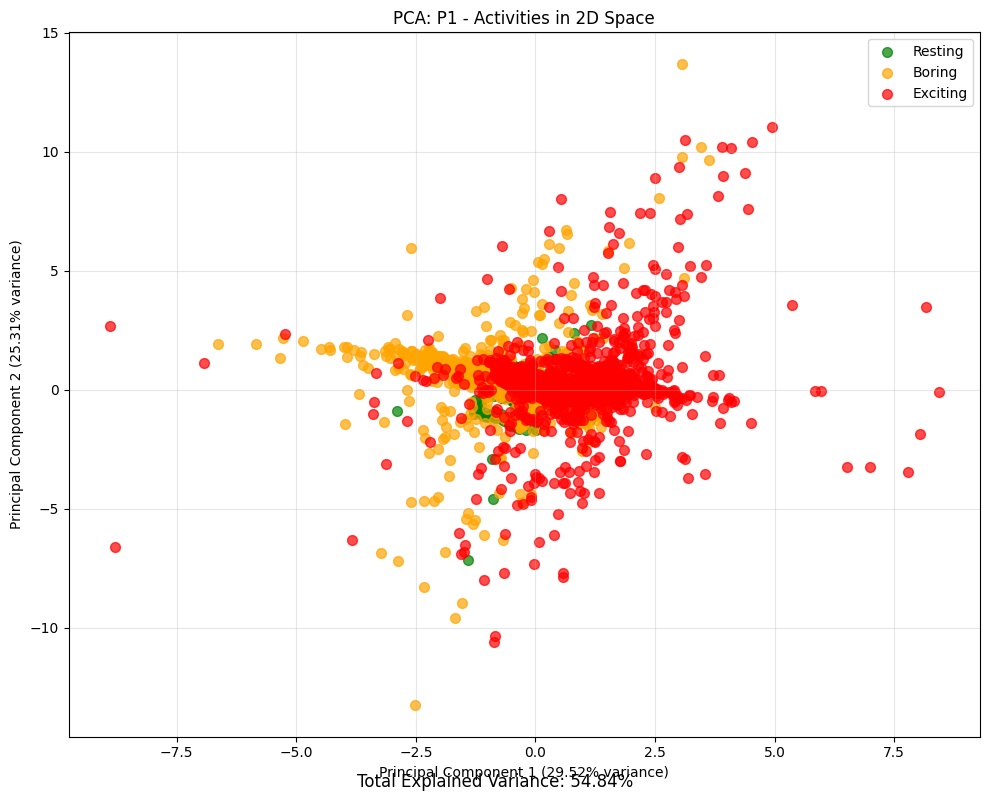


P1 - PCA Feature Importance:
                            PC1       PC2
wrist_accel_magnitude  0.215229  0.904488
ankle_accel_magnitude -0.482365  0.116457
ecg_value              0.650520  0.117005
orientation            0.545732 -0.393254


<Figure size 1000x600 with 0 Axes>

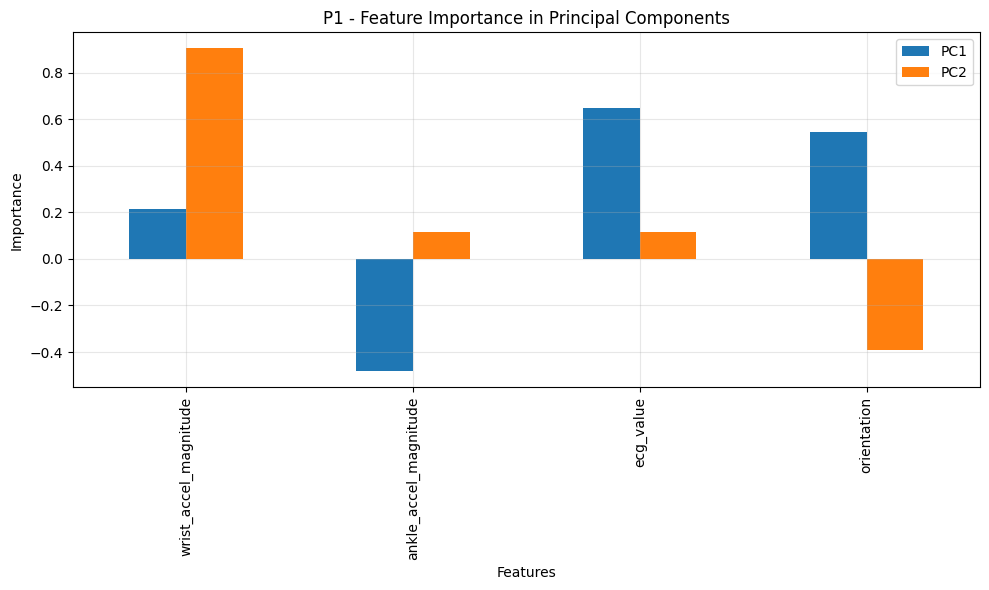


Performing PCA for p2...


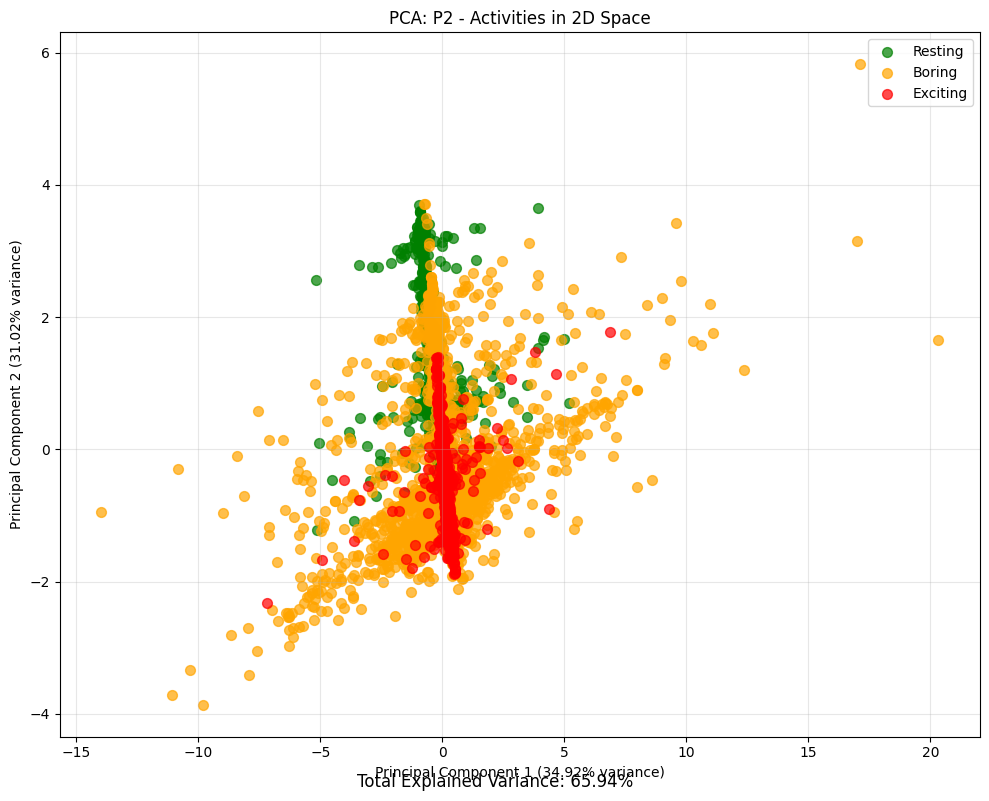


P2 - PCA Feature Importance:
                            PC1       PC2
wrist_accel_magnitude  0.702662  0.082098
ankle_accel_magnitude  0.679632  0.216556
ecg_value             -0.147184  0.694002
orientation           -0.150680  0.681707


<Figure size 1000x600 with 0 Axes>

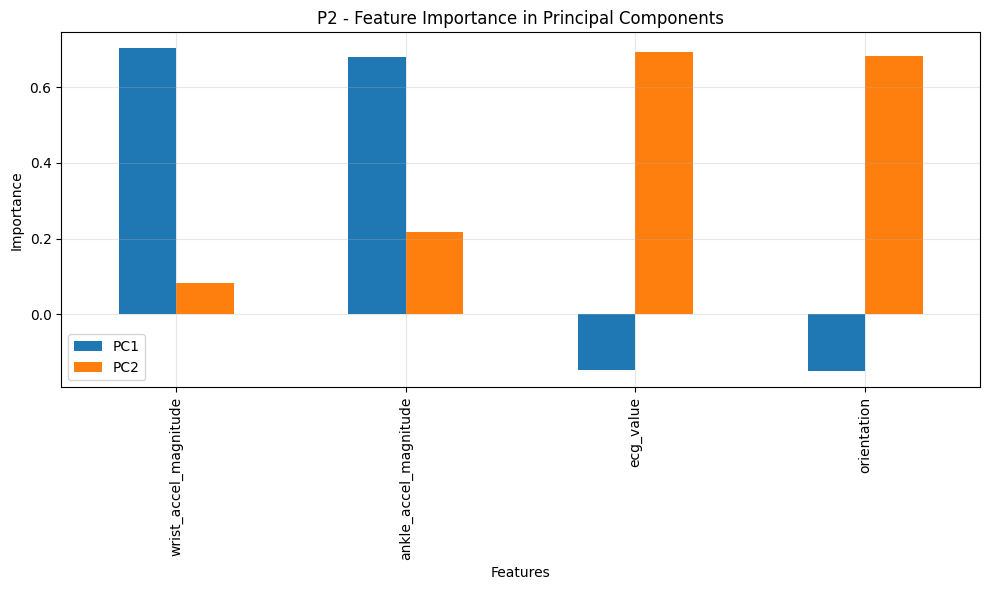

In [5]:
def prepare_data_for_pca(participant_id):
    if participant_id not in activity_data:
        print(f"No data available for {participant_id}")
        return None, None

    # Features to use for dimensionality reduction
    features = ['wrist_accel_magnitude', 'ankle_accel_magnitude', 'ecg_value', 'orientation']

    # Combine all activity data with activity labels
    combined_data = []
    activity_labels = []
    activity_colors = []

    for activity, df in activity_data[participant_id].items():
        # Select only the relevant features
        activity_features = df[features].copy()

        # Add to combined data
        combined_data.append(activity_features)

        # Add labels and colors
        activity_labels.extend([activity] * len(activity_features))
        activity_colors.extend([df['color'].iloc[0]] * len(activity_features))

    # Combine all activities into one dataframe
    if combined_data:
        combined_df = pd.concat(combined_data, ignore_index=True)

        # Handle any missing values
        combined_df = combined_df.fillna(0)

        return combined_df, activity_labels, activity_colors
    else:
        return None, None, None

def perform_pca(participant_id):
    # Prepare data
    data, labels, colors = prepare_data_for_pca(participant_id)

    if data is None:
        print(f"No data prepared for {participant_id}")
        return

    # Standardize the features
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Perform PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data_scaled)

    # Create dataframe with PCA results
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    pca_df['activity'] = labels
    pca_df['color'] = colors

    # Calculate explained variance
    explained_variance = pca.explained_variance_ratio_

    # Visualize PCA results
    plt.figure(figsize=(10, 8))

    # Plot each activity with its color
    for activity in pca_df['activity'].unique():
        subset = pca_df[pca_df['activity'] == activity]
        color = subset['color'].iloc[0]
        plt.scatter(subset['PC1'], subset['PC2'],
                   c=color, label=activity.capitalize(), alpha=0.7, s=50)

    plt.title(f'PCA: {participant_id.upper()} - Activities in 2D Space')
    plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.2%} variance)')
    plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.2%} variance)')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Add total explained variance
    total_variance = sum(explained_variance)
    plt.figtext(0.5, 0.01, f'Total Explained Variance: {total_variance:.2%}',
               ha='center', fontsize=12)

    # Save figure
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir, participant_id, 'dim_reduction', 'pca_visualization.png'), dpi=300)
    plt.show()

    # Get feature importance
    feature_columns = data.columns
    components = pd.DataFrame(pca.components_.T, index=feature_columns,
                             columns=['PC1', 'PC2'])

    # Display feature importance
    print(f"\n{participant_id.upper()} - PCA Feature Importance:")
    print(components)

    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    components.plot(kind='bar', figsize=(10, 6))
    plt.title(f'{participant_id.upper()} - Feature Importance in Principal Components')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir, participant_id, 'dim_reduction', 'pca_feature_importance.png'), dpi=300)
    plt.show()

    return pca_df, pca

# Perform PCA for both participants
pca_results = {}
for participant in ['p1', 'p2']:
    print(f"\nPerforming PCA for {participant}...")
    pca_results[participant] = perform_pca(participant)


Performing t-SNE for p1...


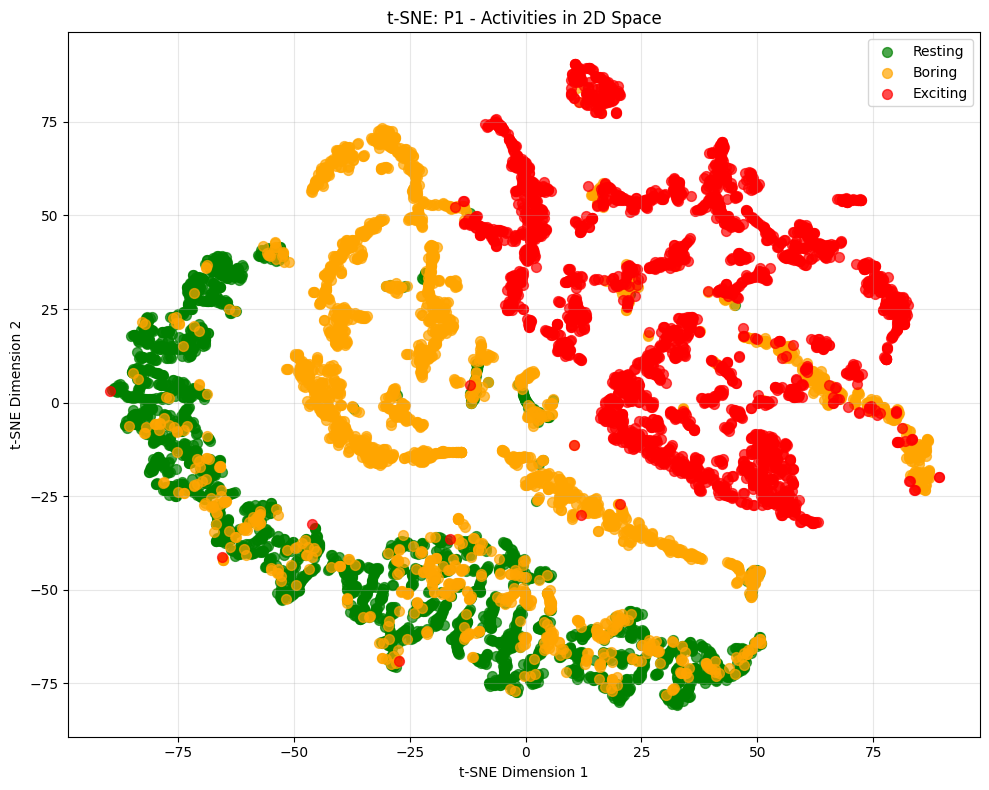


Performing t-SNE for p2...


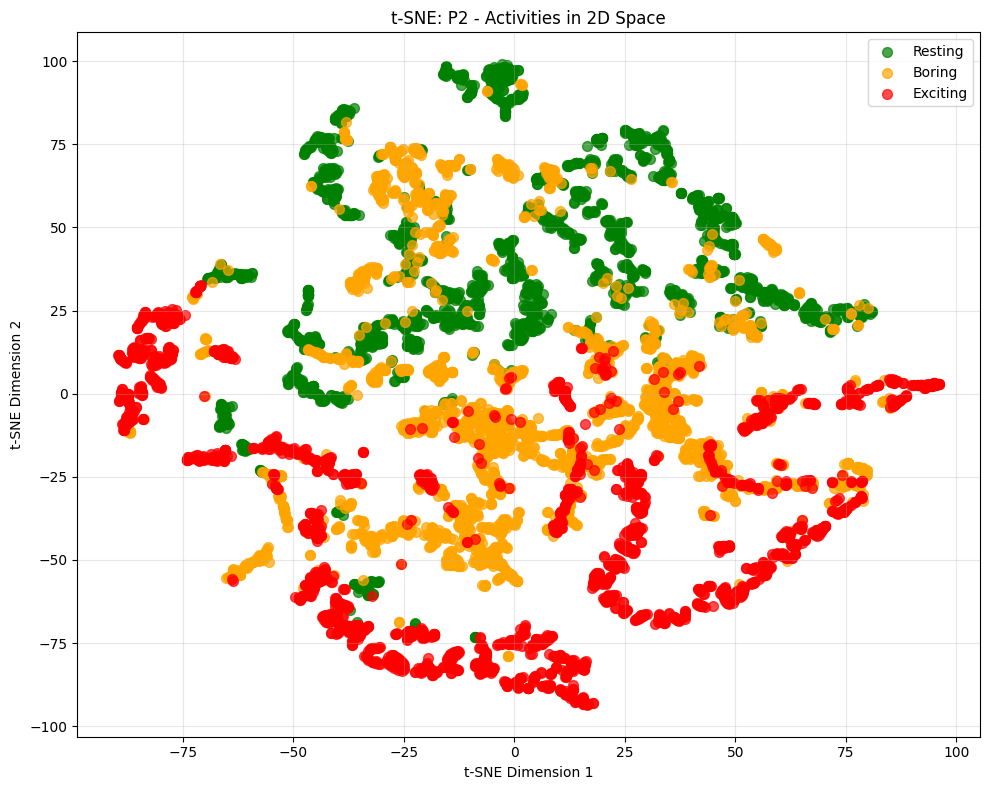

In [6]:
def perform_tsne(participant_id):
    # Prepare data
    data, labels, colors = prepare_data_for_pca(participant_id)

    if data is None:
        print(f"No data prepared for {participant_id}")
        return

    # Standardize the features
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(data)//10))
    tsne_results = tsne.fit_transform(data_scaled)

    # Create dataframe with t-SNE results
    tsne_df = pd.DataFrame(data=tsne_results, columns=['t-SNE1', 't-SNE2'])
    tsne_df['activity'] = labels
    tsne_df['color'] = colors

    # Visualize t-SNE results
    plt.figure(figsize=(10, 8))

    # Plot each activity with its color
    for activity in tsne_df['activity'].unique():
        subset = tsne_df[tsne_df['activity'] == activity]
        color = subset['color'].iloc[0]
        plt.scatter(subset['t-SNE1'], subset['t-SNE2'],
                   c=color, label=activity.capitalize(), alpha=0.7, s=50)

    plt.title(f't-SNE: {participant_id.upper()} - Activities in 2D Space')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Save figure
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir, participant_id, 'dim_reduction', 'tsne_visualization.png'), dpi=300)
    plt.show()

    return tsne_df

# Perform t-SNE for both participants (optional)
tsne_results = {}
for participant in ['p1', 'p2']:
    print(f"\nPerforming t-SNE for {participant}...")
    tsne_results[participant] = perform_tsne(participant)


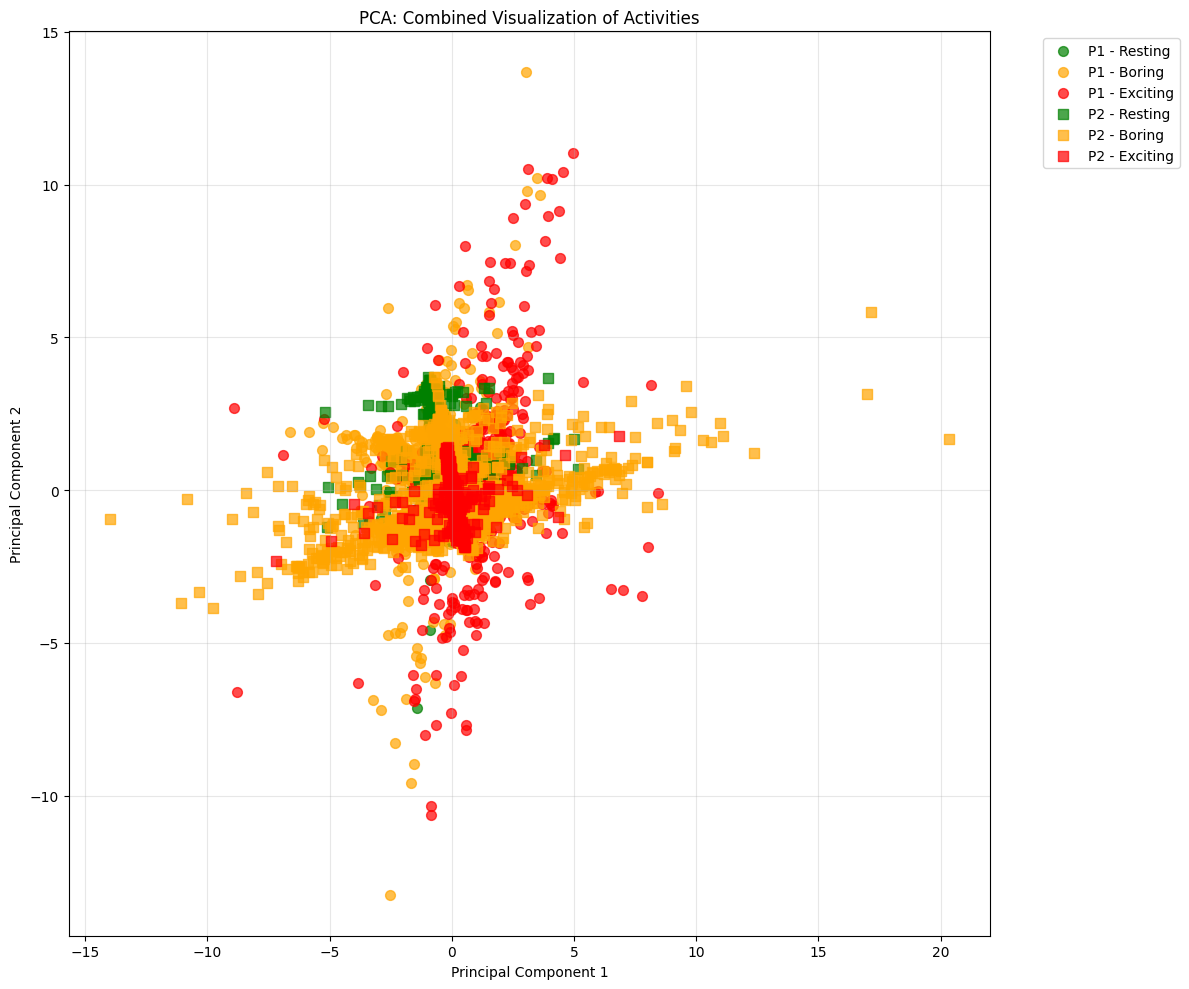

In [7]:
def combined_pca_visualization():
    if 'p1' not in pca_results or 'p2' not in pca_results:
        print("PCA results not available for both participants")
        return

    plt.figure(figsize=(12, 10))

    # Get data from both participants
    for participant, (pca_df, _) in pca_results.items():
        if pca_df is None:
            continue

        marker = 'o' if participant == 'p1' else 's'  # circle for p1, square for p2

        # Plot each activity with its color
        for activity in pca_df['activity'].unique():
            subset = pca_df[pca_df['activity'] == activity]
            color = subset['color'].iloc[0]
            label = f"{participant.upper()} - {activity.capitalize()}"
            plt.scatter(subset['PC1'], subset['PC2'],
                       c=color, marker=marker, label=label, alpha=0.7, s=50)

    plt.title('PCA: Combined Visualization of Activities')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Save figure
    plt.tight_layout()
    for participant in ['p1', 'p2']:
        plt.savefig(os.path.join(base_dir, participant, 'dim_reduction', 'combined_pca.png'), dpi=300)
    plt.show()

# Create combined visualization
combined_pca_visualization()

Saved combined t-SNE visualization to: /content/drive/MyDrive/mhealth/study/test_submission/p1/dim_reduction/combined_tsne.png
Saved combined t-SNE visualization to: /content/drive/MyDrive/mhealth/study/test_submission/p2/dim_reduction/combined_tsne.png


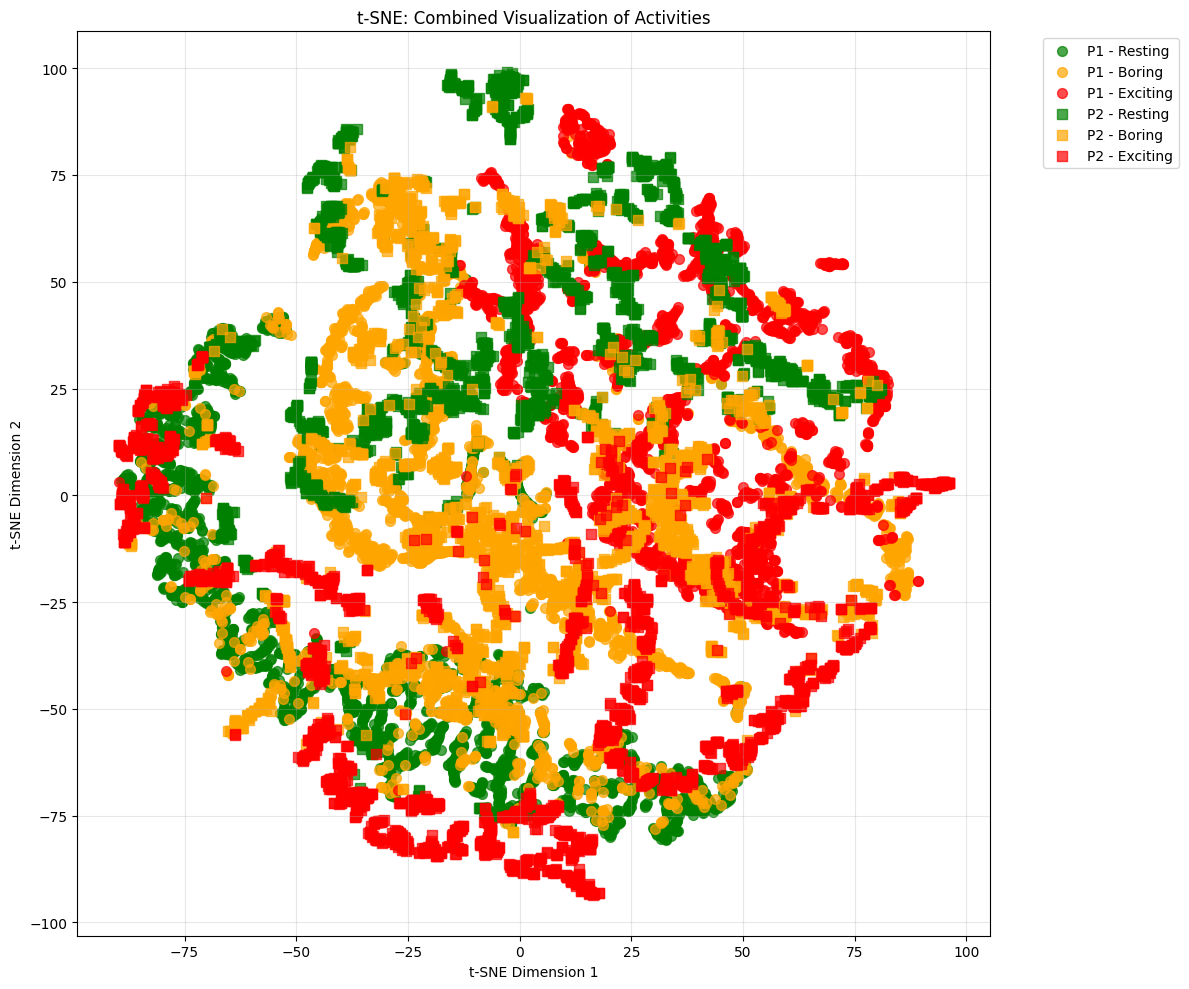

In [8]:
def combined_tsne_visualization():
    if 'p1' not in tsne_results or 'p2' not in tsne_results:
        print("t-SNE results not available for both participants")
        return

    plt.figure(figsize=(12, 10))

    # Get data from both participants
    for participant, tsne_df in tsne_results.items():
        if tsne_df is None:
            continue

        marker = 'o' if participant == 'p1' else 's'  # circle for p1, square for p2

        # Plot each activity with its color
        for activity in tsne_df['activity'].unique():
            subset = tsne_df[tsne_df['activity'] == activity]
            color = subset['color'].iloc[0]
            label = f"{participant.upper()} - {activity.capitalize()}"
            plt.scatter(subset['t-SNE1'], subset['t-SNE2'],
                       c=color, marker=marker, label=label, alpha=0.7, s=50)

    plt.title('t-SNE: Combined Visualization of Activities')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Create directories if they don't exist
    for participant in ['p1', 'p2']:
        save_dir = os.path.join(base_dir, participant, 'dim_reduction')
        os.makedirs(save_dir, exist_ok=True)

    # Save figure
    plt.tight_layout()
    for participant in ['p1', 'p2']:
        save_path = os.path.join(base_dir, participant, 'dim_reduction', 'combined_tsne.png')
        plt.savefig(save_path, dpi=300)
        print(f"Saved combined t-SNE visualization to: {save_path}")

    plt.show()

# Run the combined t-SNE visualization
combined_tsne_visualization()